# Computer Vision Homework 3

## Setup

In [ ]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.lines as mlines


# input_image = cv2.imread('jukan-tateisi-bJhT_8nbUA0-unsplash-1024x576.jpg.optimal.jpg')
# input_image = cv2.cvtColor(src=input_image, code=cv2.COLOR_BGR2RGB)

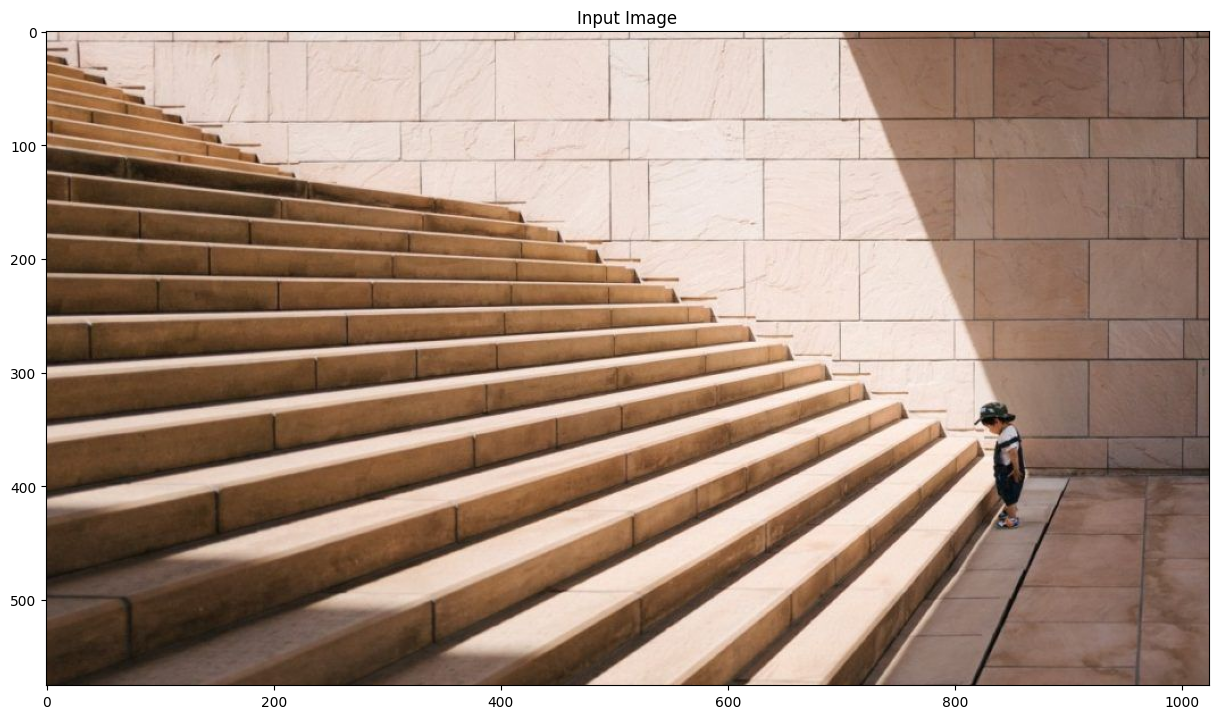

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('Input Image')
plt.imshow(input_image.astype('uint8'))
plt.show()

## Points generation

120


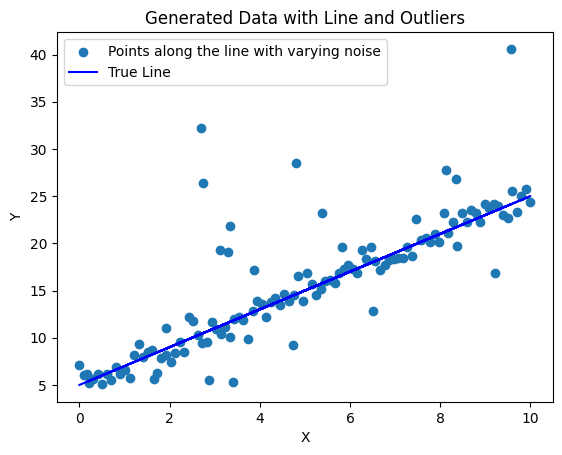

In [ ]:
# Function to generate points along a line with varying noise
def generate_line_points(num_points, a, b, base_noise, outlier_noise, num_outliers):
    x = np.linspace(0, 10, num_points)

    # Generate points along the line with base noise
    y = a * x + b + np.random.normal(0, base_noise, num_points)

    # Generate outliers along the same line with different noise
    outlier_indices = np.random.choice(num_points, num_outliers, replace=False)

    # Generate new outlier points without modifying the original values
    new_outliers_x = np.random.uniform(min(x), max(x), num_outliers)
    new_outliers_y = a * new_outliers_x + b + np.random.normal(0, outlier_noise, num_outliers)

    # Combine the original points with the new outlier points
    x_outliers = np.concatenate([x, new_outliers_x])
    y_outliers = np.concatenate([y, new_outliers_y])

    return np.column_stack((x_outliers, y_outliers))

# Parameters for the line
a = 2
b = 5
base_noise = 1
outlier_noise = 10

# Generate points along the line with varying noise
num_points = 100
num_outliers = 20
line_points = generate_line_points(num_points, a, b, base_noise, outlier_noise, num_outliers)

# Plot the generated points
line_x, line_y = zip(*line_points)

# Plot the generated points
plt.scatter(line_points[:, 0], line_points[:, 1], label='Points along the line with varying noise')
plt.plot(line_points[:, 0], a * line_points[:, 0] + b, color='blue', label='True Line')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Generated Data with Line and Outliers')
plt.show()


## Ransac

Linear Regression Best fit parameters: [5.770362563348705, 2.000885138046121]
Linear Regression Error: 14.824619111483514
Ransac Best fit parameters: [4.67966317 2.01393137]
Ransac Error: 2.542115235206211


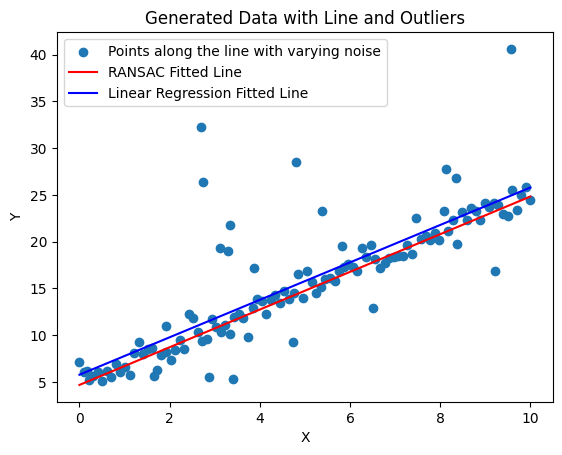

In [ ]:
def ransac(points, n, threshold=5, max_iter=100):
  iter = 0
  best_inliers = []
  while iter < max_iter:
    samples = np.random.choice(len(points), n)
    samples_points = points[samples]
    X_samples = samples_points[:, 0]
    Y_samples = samples_points[:, 1]
    X_samples = np.column_stack((np.ones(n), X_samples))
    try:
      model_params = np.linalg.inv(X_samples.T @ X_samples) @ X_samples.T @ Y_samples
    except np.linalg.LinAlgError:
      iter += 1
      continue
    distances = np.abs(model_params[0] * points[:, 0] + model_params[1] - points[:, 1])
    inliers = np.where(distances < threshold)[0]
    if len(inliers) > len(best_inliers):
            best_inliers = inliers
    iter +=1

  best_fit_points = points[best_inliers]
  X = best_fit_points[:, 0]
  Y = best_fit_points[:, 1]
  X = np.column_stack((np.ones(len(X)), X))
  try:
      best_P = np.linalg.inv(X.T @ X) @ X.T @ Y
      residuals = Y - (X @ best_P)
      error = np.mean(residuals**2)
      return best_P, error
  except np.linalg.LinAlgError:
      # Handle the case where the matrix is still singular
      return None, None

best_p, error_ransac = ransac(line_points, 2)

X_lr = line_points[:, 0].reshape(-1, 1)
y_lr = line_points[:, 1]
lr_model = LinearRegression().fit(X_lr, y_lr)

# Get the linear regression parameters
lr_params = [lr_model.intercept_, lr_model.coef_[0]]

# Predict using the linear regression model
y_lr_pred = lr_model.predict(X_lr)

# Calculate the mean squared error for linear regression
error_lr = mean_squared_error(y_lr, y_lr_pred)

print("Linear Regression Best fit parameters:", lr_params)
print("Linear Regression Error:", error_lr)

print("Ransac Best fit parameters:", best_p)
print("Ransac Error:", error_ransac)

x_range = np.linspace(min(line_points[:, 0]), max(line_points[:, 0]), 100)
y_range = best_p[0] + best_p[1] * x_range
plt.scatter(line_points[:, 0], line_points[:, 1], label='Points along the line with varying noise')
plt.plot(x_range, y_range, color='red', label='RANSAC Fitted Line')
plt.plot(x_range, lr_params[0] + lr_params[1] * x_range, color='blue', label='Linear Regression Fitted Line')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Generated Data with Line and Outliers')
plt.show()

In [ ]:
def hough_transform(image, edge_image, num_rhos=90, num_thetas=90, t_count=500, max_lines=200):
  edge_height, edge_width = edge_image.shape[:2]
  edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
  #
  d = np.sqrt(np.square(edge_height) + np.square(edge_width))
  dtheta = 180 / num_thetas
  drho = (2 * d) / num_rhos
  #
  thetas = np.arange(0, 180, step=dtheta)
  rhos = np.arange(-d, d, step=drho)
  #
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  #
  accumulator = np.zeros((len(rhos), len(rhos)))
  #
  figure = plt.figure(figsize=(12, 12))
  subplot1 = figure.add_subplot(1, 4, 1)
  subplot1.imshow(image)
  subplot2 = figure.add_subplot(1, 4, 2)
  subplot2.imshow(edge_image, cmap="gray")
  subplot3 = figure.add_subplot(1, 4, 3)
  subplot3.set_facecolor((0, 0, 0))
  subplot4 = figure.add_subplot(1, 4, 4)
  subplot4.imshow(image)
  #
  edge_points = np.argwhere(edge_image != 0)
  edge_points = edge_points - np.array([[edge_height_half, edge_width_half]])
  #
  rho_values = np.matmul(edge_points, np.array([sin_thetas, cos_thetas]))
  #
  accumulator, theta_vals, rho_vals = np.histogram2d(
      np.tile(thetas, rho_values.shape[0]),
      rho_values.ravel(),
      bins=[thetas, rhos]
  )
  accumulator = np.transpose(accumulator)
  lines = np.argwhere(accumulator > t_count)
  rho_idxs, theta_idxs = lines[:, 0], lines[:, 1]
  r, t = rhos[rho_idxs], thetas[theta_idxs]
  sorted_lines = sorted(zip(rho_idxs, theta_idxs), key=lambda x: accumulator[x[0], x[1]], reverse=True)

  # Extract the top N lines
  sorted_lines = sorted_lines[:max_lines]
  for ys in rho_values:
    subplot3.plot(thetas, ys, color="white", alpha=0.05)


  for line in sorted_lines:
    y, x = line
    rho = rhos[y]
    theta = thetas[x]
    a = np.cos(np.deg2rad(theta))
    b = np.sin(np.deg2rad(theta))
    x0 = (a * rho) + edge_width_half
    y0 = (b * rho) + edge_height_half
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    normalized_value = accumulator[y, x] / accumulator.max()
    color = plt.cm.rainbow(normalized_value)  # Use a different colormap (e.g., plt.cm.rainbow)
    subplot4.plot([x1, x2], [y1, y2], color=color)

  subplot3.invert_yaxis()
  subplot3.invert_xaxis()

  subplot1.title.set_text("Original Image")
  subplot2.title.set_text("Edge Image")
  subplot3.title.set_text("Hough Space")
  subplot4.title.set_text("Detected Lines")
  plt.show()
  return accumulator, rhos, thetas

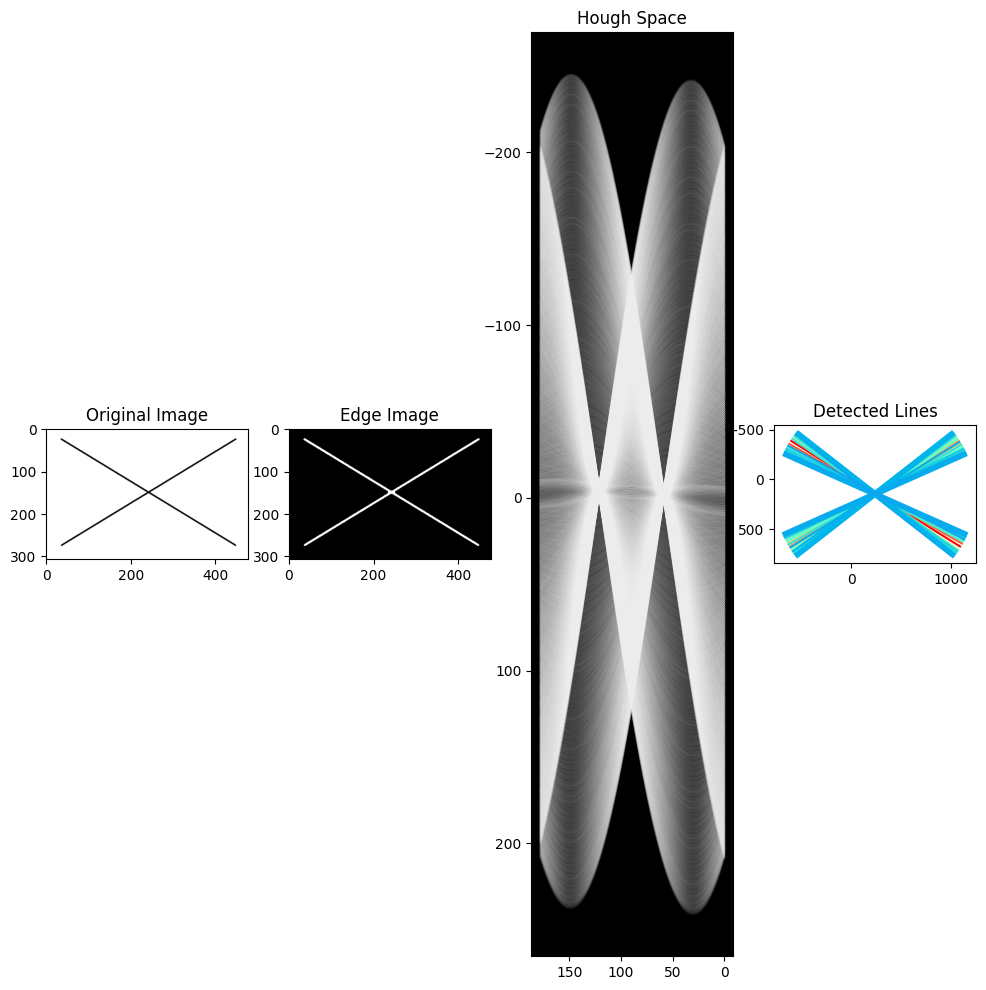

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-5.68636967e+02, -5.56000590e+02, -5.43364213e+02, -5.30727836e+02,
        -5.18091459e+02, -5.05455082e+02, -4.92818705e+02, -4.80182328e+02,
        -4.67545950e+02, -4.54909573e+02, -4.42273196e+02, -4.29636819e+02,
        -4.17000442e+02, -4.04364065e+02, -3.91727688e+02, -3.79091311e+02,
        -3.66454934e+02, -3.53818557e+02, -3.41182180e+02, -3.28545803e+02,
        -3.15909426e+02, -3.03273049e+02, -2.90636672e+02, -2.78000295e+02,
        -2.65363918e+02, -2.52727541e+02, -2.40091164e+02, -2.27454787e+02,
        -2.14818410e+02, -2.02182033e+02, -1.89545656e+02, -1.76909279e+02,
        -1.64272902e+02, -1.51636524e+02, -1.39000147e+02, -1.26363770e+02,
        -1.13727393e+02, -1.01091016e+02, -8.84546393e+01, -7.58182

In [ ]:
input_image = cv2.imread('straight_line_example.png')
input_image = cv2.cvtColor(src=input_image, code=cv2.COLOR_BGR2RGB)
edge_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
edge_image = cv2.Canny(edge_image, 100, 200)
edge_image = cv2.dilate(
    edge_image,
    cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)),
    iterations=1
)
edge_image = cv2.erode(
    edge_image,
    cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)),
    iterations=1
)
hough_transform(input_image, edge_image)

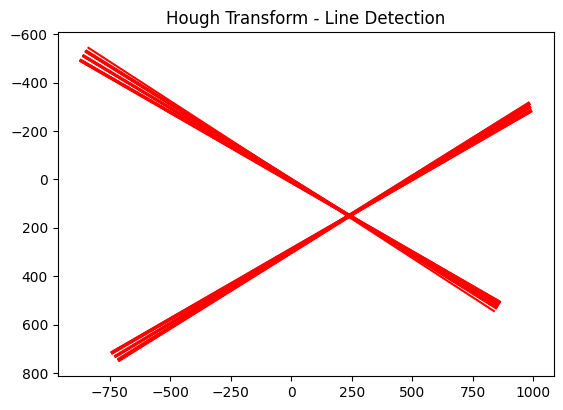

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def hough_transform(image, theta_res=1, rho_res=1):
    # Compute the Hough Transform for lines in the image
    height, width = image.shape
    max_rho = int(np.sqrt(height**2 + width**2))
    rhos = np.arange(-max_rho, max_rho, rho_res)
    thetas = np.deg2rad(np.arange(-90, 90, theta_res))
    num_thetas = len(thetas)

    # Initialize Hough accumulator
    accumulator = np.zeros((len(rhos), num_thetas), dtype=np.uint64)

    # Find non-zero pixels in the binary image
    y, x = np.nonzero(image)

    for i in range(len(x)):
        for j in range(num_thetas):
            rho = int(x[i] * np.cos(thetas[j]) + y[i] * np.sin(thetas[j]))
            rho_idx = np.argmin(np.abs(rhos - rho))
            accumulator[rho_idx, j] += 1

    return accumulator, thetas, rhos

def find_lines(image, threshold=100):
    # Apply the Hough Transform and find lines
    edges = cv2.Canny(image, 50, 150)
    accumulator, thetas, rhos = hough_transform(edges)

    # Find indices of accumulator values above the threshold
    indices = np.argwhere(accumulator > threshold)

    # Extract rho and theta values corresponding to the indices
    lines = [(rhos[i[0]], thetas[i[1]]) for i in indices]

    return lines

def plot_lines(image, lines):
    # Plot the lines on the original image
    plt.imshow(image, cmap='gray')
    for line in lines:
        rho, theta = line
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        plt.plot([x1, x2], [y1, y2], 'r')

    plt.title('Hough Transform - Line Detection')
    plt.show()

# Read an example image
image_path = 'straight_line_example.png'  # Replace with the path to your image
input_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Find lines in the image
lines = find_lines(input_image)

# Plot the original image with detected lines
plot_lines(input_image, lines)

## Good Hough

In [ ]:
def hough_transform_(raw_image, edge_image, max_lines, rho_step=1, theta_step=1, t_count=500):
  height, width = edge_image.shape
  diag = np.ceil(np.sqrt(height ** 2 + width ** 2))
  rhos = np.arange(-diag, diag + 1, rho_step)
  thetas = np.deg2rad(np.arange(-90, 90, theta_step))

  accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
  y_edges, x_edges = np.nonzero(edge_image)
  for i in range(len(x_edges)):
    for j in range(len(thetas)):
      y, x = y_edges[i], x_edges[i]
      rho = int(x * np.cos(thetas[j]) + y * np.sin(thetas[j]) + diag)
      accumulator[rho, j] += 1

  max_points_indices = np.argpartition(accumulator.flatten(), -2)[-max_lines:]
  max_points = np.vstack(np.unravel_index(max_points_indices, accumulator.shape)).T
  fig = plt.figure(figsize=(15, 10))
  fig.suptitle('Hough Space')

  plt.imshow(np.log1p(accumulator), cmap='jet', extent=[np.rad2deg(thetas.min()), np.rad2deg(thetas.max()), rhos.min(), rhos.max()])
  plt.tight_layout()
  plt.show()

  image_with_lines = raw_image.copy()
  lines = []

  for i in range(len(max_points)):
        # reverse engineer lines from rhos and thetas
        rho = rhos[max_points[i][0]]
        theta = thetas[max_points[i][1]]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        # these are then scaled so that the lines go off the edges of the image
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(image_with_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)
        lines.append((x1,y1,x2,y2))

  # Plot Original Image and Detected Lines
  plt.figure(figsize=(12, 6))

  # Original Image
  plt.subplot(1, 2, 1)
  plt.imshow(raw_image, cmap='gray', extent=[0, width, height, 0])
  plt.title('Original Image')

  # Detected Lines Image
  plt.subplot(1, 2, 2)
  plt.imshow(image_with_lines, extent=[0, width, height, 0])
  plt.title('Detected Lines')
  plt.axis('equal')  # Set equal aspect ratio

  plt.tight_layout()
  plt.show()

  return accumulator, max_points, lines, rhos, thetas




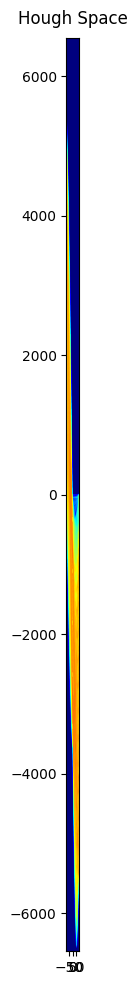

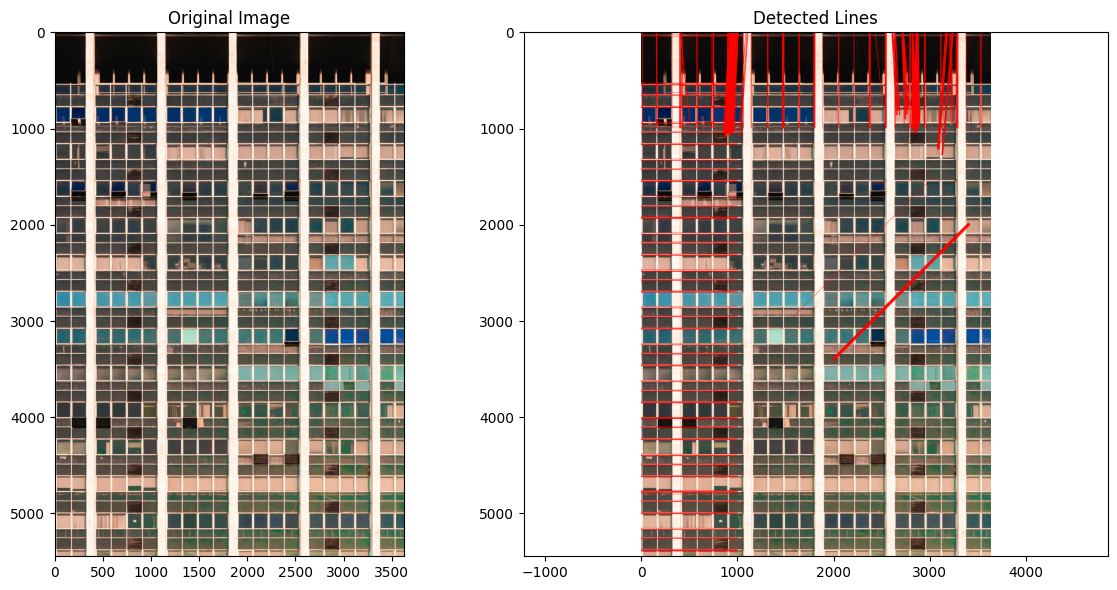

In [ ]:
input_image = cv2.imread('pexels-athena-2081204.jpg')
input_image = cv2.cvtColor(src=input_image, code=cv2.COLOR_BGR2RGB)
edge_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
edge_image = cv2.Canny(edge_image, 30, 100)
hough_transform_(input_image, edge_image, 1000)

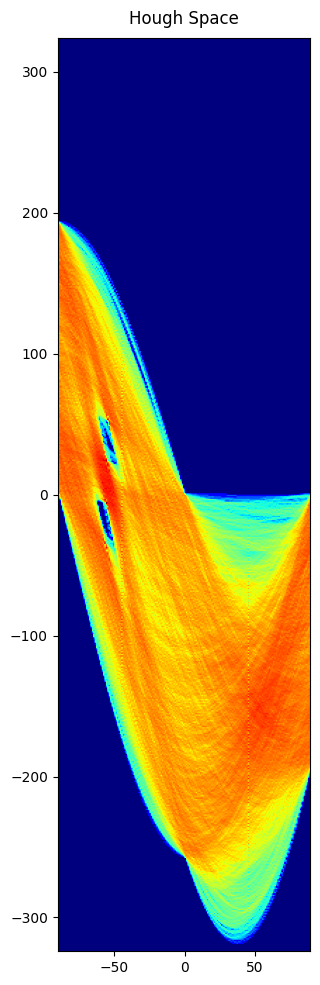

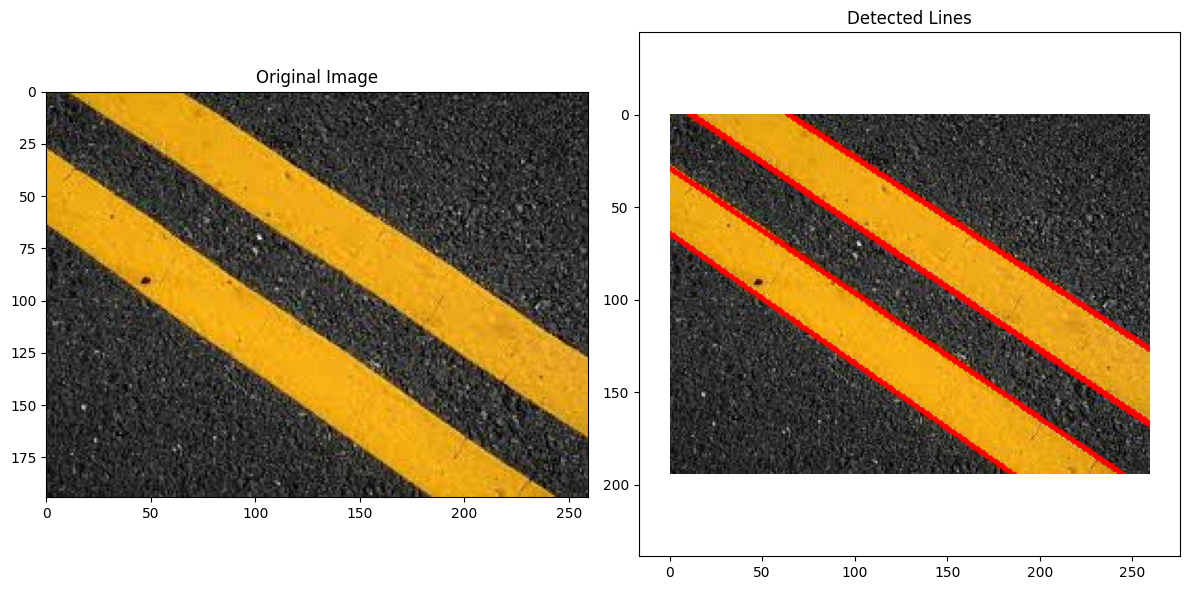

In [ ]:
input_image = cv2.imread('images.jpg')
input_image = cv2.cvtColor(src=input_image, code=cv2.COLOR_BGR2RGB)
edge_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
edge_image = cv2.Canny(edge_image, 30, 100)
hough_transform_(input_image, edge_image, 5)

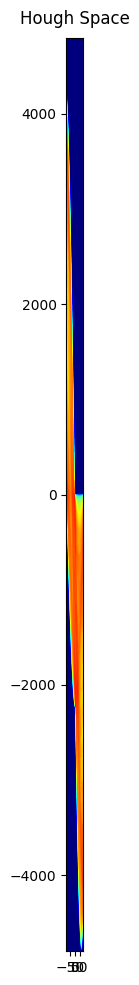

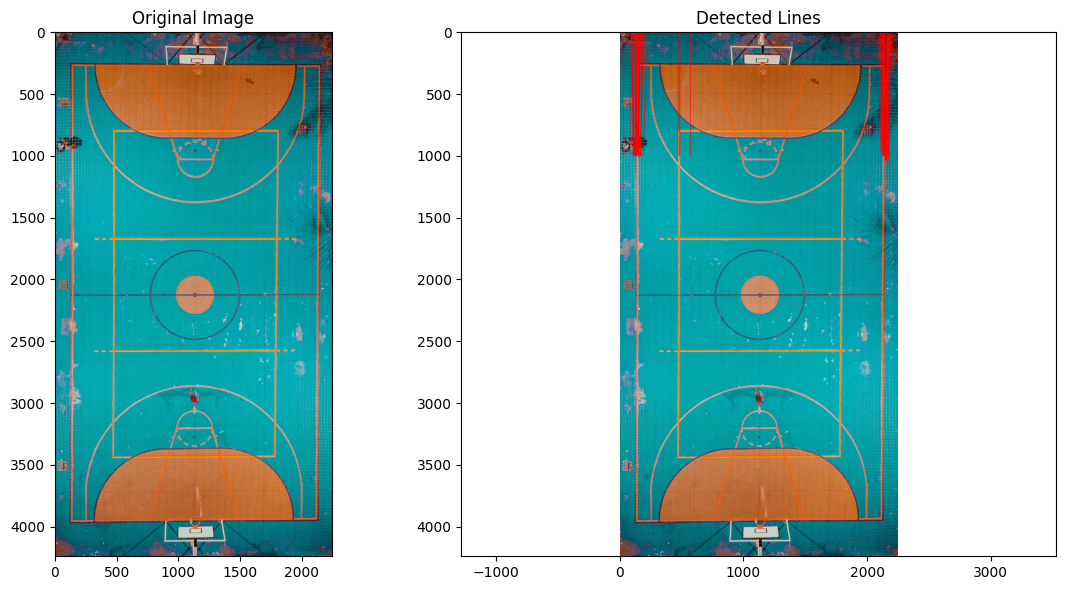

In [ ]:
input_image = cv2.imread('pexels-sergio-souza-2260849.jpg')
input_image = cv2.cvtColor(src=input_image, code=cv2.COLOR_BGR2RGB)
edge_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
edge_image = cv2.Canny(edge_image, 30, 100)
hough_transform_(input_image, edge_image, 100)

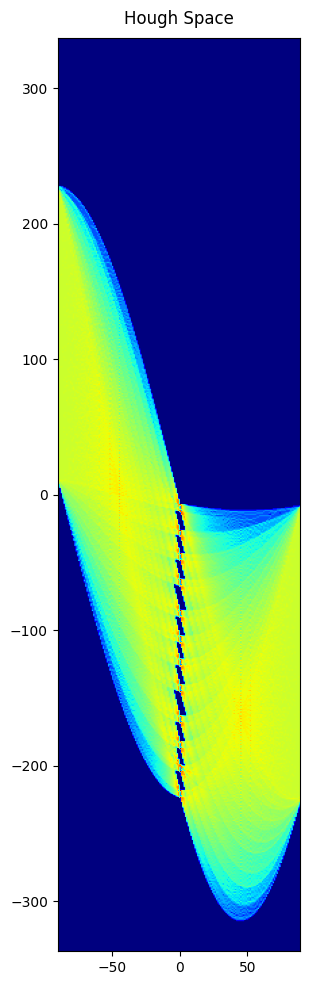

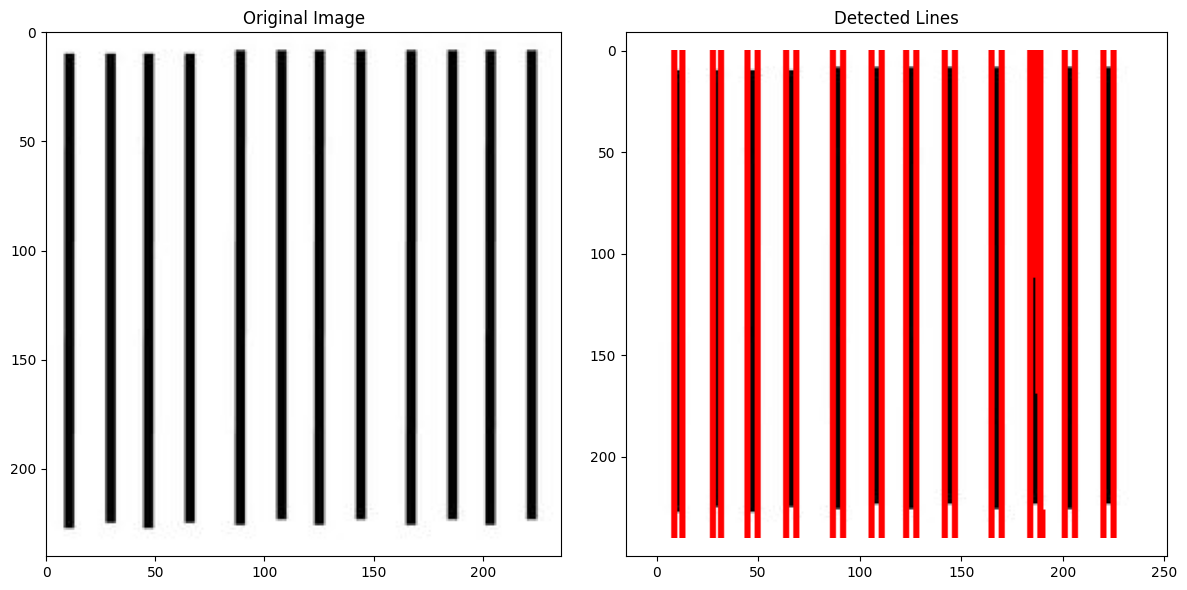

In [ ]:
input_image = cv2.imread('simple.jpg')
input_image = cv2.cvtColor(src=input_image, code=cv2.COLOR_BGR2RGB)
edge_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
edge_image = cv2.Canny(edge_image, 30, 100)
hough_transform_(input_image, edge_image, 25)

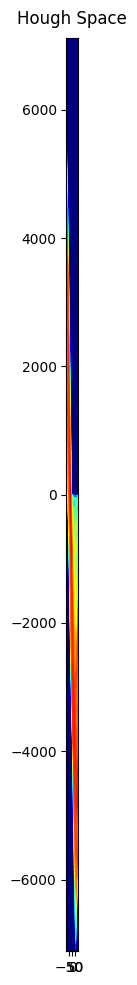

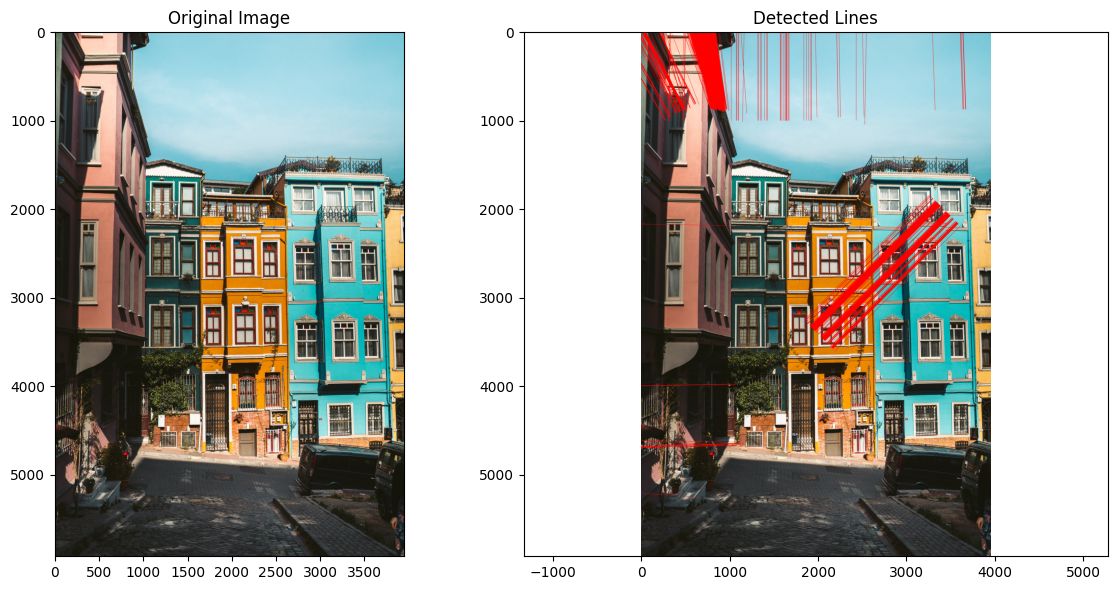

In [ ]:
input_image = cv2.imread('image1.jpg')
input_image = cv2.cvtColor(src=input_image, code=cv2.COLOR_BGR2RGB)
edge_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
edge_image = cv2.Canny(edge_image, 30, 100)
hough_transform_(input_image, edge_image, 1000)

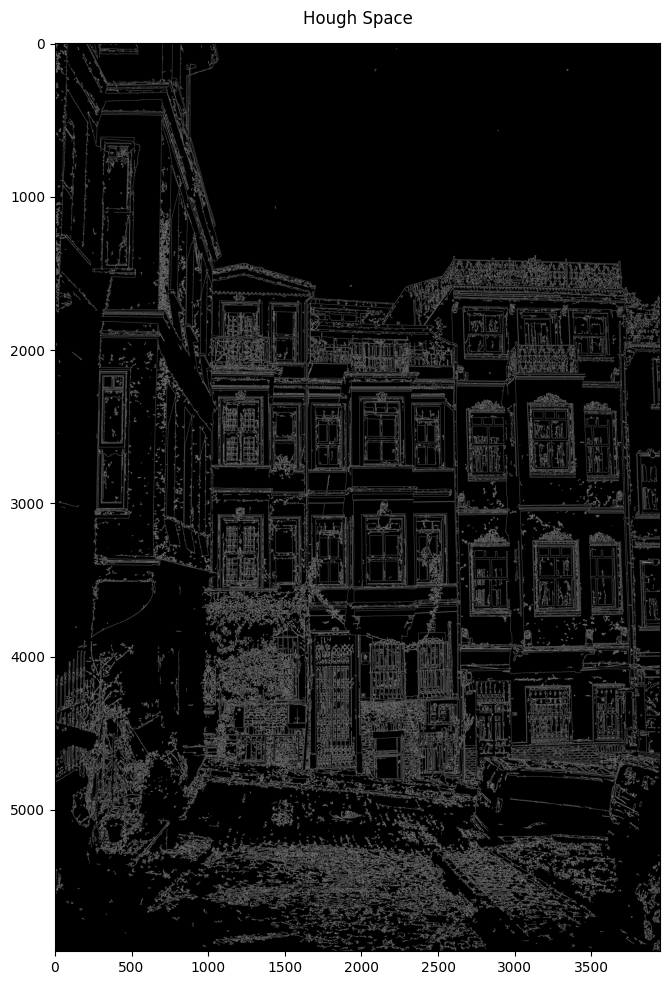

In [ ]:
input_image = cv2.imread('image1.jpg')
input_image = cv2.cvtColor(src=input_image, code=cv2.COLOR_BGR2RGB)
edge_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
edge_image = cv2.Canny(edge_image, 30, 100)
# hough_transform_(input_image, edge_image, 1000)
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Hough Space')

plt.imshow(edge_image,  cmap="gray")
plt.tight_layout()
plt.show()

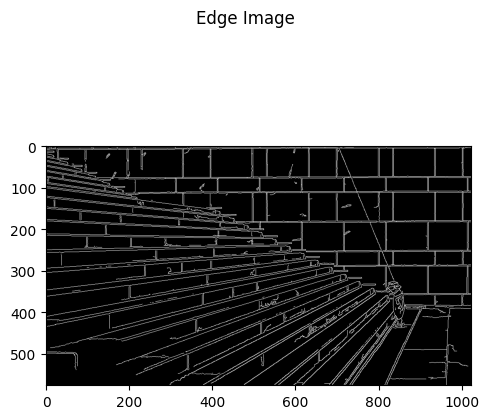

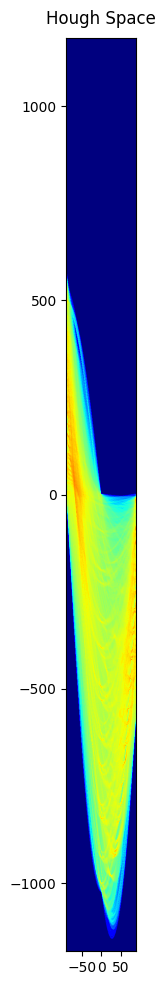

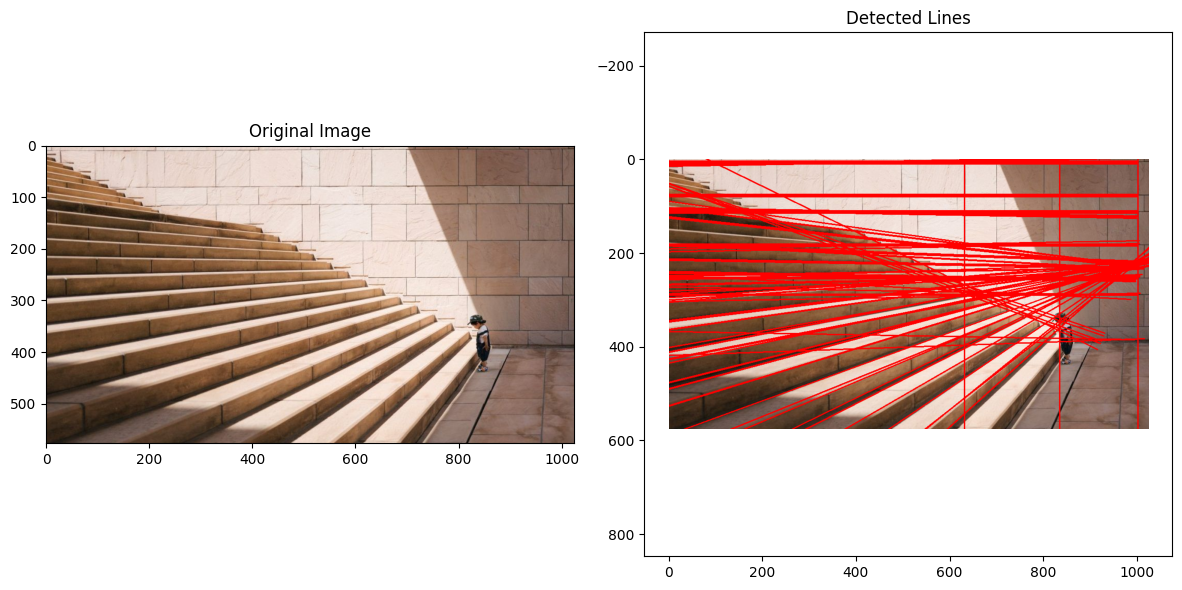

In [ ]:
input_image = cv2.imread('jukan-tateisi-bJhT_8nbUA0-unsplash-1024x576.jpg.optimal.jpg')
input_image = cv2.cvtColor(src=input_image, code=cv2.COLOR_BGR2RGB)
edge_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
edge_image = cv2.Canny(edge_image, 30, 100)
fig = plt.figure(figsize=(5, 5))
fig.suptitle('Edge Image')
plt.imshow(edge_image,  cmap="gray")
plt.tight_layout()
plt.show()
hough_transform_(input_image, edge_image, 100)

## Rectangle Detection

In [61]:
def lines_are_parallel(line1, line2, rho_threshold=25):
    # Check if two lines are approximately parallel based on their rhos
    rho1 = line1[4]
    rho2 = line2[4]
    rho_diff = np.abs(rho1 - rho2)
    return rho_diff <= rho_threshold

def line_intersection(line1, line2):
  x1, y1, x2, y2, rho1, theta1 = line1
  x3, y3, x4, y4, rho2, theta2 = line2
  determinant = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
  if determinant == 0:
      return None  # Lines are parallel or coincident

  intersection_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / determinant
  intersection_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / determinant

  return [intersection_x, intersection_y]


def construct_rectangle(parallel_pair, perpendicular_pair):
    # Construct rectangle from intersection points of lines
    intersection1 = line_intersection(parallel_pair[0], perpendicular_pair[0])
    intersection2 = line_intersection(parallel_pair[0], perpendicular_pair[1])
    intersection3 = line_intersection(parallel_pair[1], perpendicular_pair[0])
    intersection4 = line_intersection(parallel_pair[1], perpendicular_pair[1])
    return [intersection1, intersection2, intersection3, intersection4]


def hough_transform_rectangular(raw_image, edge_image, max_lines, theta_threshold=10, rho_step=1, theta_step=1, perpendicular_threshold=np.pi / 3):
  height, width = edge_image.shape
  diag = np.ceil(np.sqrt(height ** 2 + width ** 2))
  rhos = np.arange(-diag, diag + 1, rho_step)
  thetas = np.deg2rad(np.arange(-90, 90, theta_step))

  accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
  y_edges, x_edges = np.nonzero(edge_image)
  for i in range(len(x_edges)):
    for j in range(len(thetas)):
      y, x = y_edges[i], x_edges[i]
      rho = int(x * np.cos(thetas[j]) + y * np.sin(thetas[j]) + diag)
      accumulator[rho, j] += 1

  max_points_indices = np.argpartition(accumulator.flatten(), -2)[-max_lines:]
  max_points = np.vstack(np.unravel_index(max_points_indices, accumulator.shape)).T
  fig = plt.figure(figsize=(15, 10))
  fig.suptitle('Hough Space')

  plt.imshow(np.log1p(accumulator), cmap='jet', extent=[np.rad2deg(thetas.min()), np.rad2deg(thetas.max()), rhos.min(), rhos.max()])
  plt.tight_layout()
  plt.show()

  image_with_lines = raw_image.copy()
  lines = []

  for i in range(len(max_points)):
        # reverse engineer lines from rhos and thetas
        rho = rhos[max_points[i][0]]
        theta = thetas[max_points[i][1]]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        # these are then scaled so that the lines go off the edges of the image
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(image_with_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)
        lines.append((x1, y1, x2, y2, rho, theta))

  perpendicular_pairs = []
  parallel_pairs = []
  for i in range(len(lines)):
    for j in range(i + 1, len(lines)):
        theta_i, rho_i = lines[i][5], lines[i][4]
        theta_j, rho_j = lines[j][5], lines[j][4]

        angle_diff = np.abs(theta_i - theta_j)
        if angle_diff % np.pi == np.pi / 2 and angle_diff >= perpendicular_threshold:
            perpendicular_pairs.append((lines[i], lines[j]))

        if angle_diff <= theta_threshold:
            parallel_pairs.append((lines[i], lines[j]))


  # Plot Original Image and Detected Lines
  plt.figure(figsize=(12, 6))

  # Original Image
  plt.subplot(1, 2, 1)
  plt.imshow(raw_image, cmap='gray', extent=[0, width, height, 0])
  plt.title('Original Image')

  # Detected Lines Image
  plt.subplot(1, 2, 2)
  plt.imshow(image_with_lines, extent=[0, width, height, 0])
  plt.title('Detected Lines')
  plt.axis('equal')  # Set equal aspect ratio

  plt.tight_layout()
  plt.show()

  return accumulator, max_points, lines, rhos, thetas, perpendicular_pairs, parallel_pairs


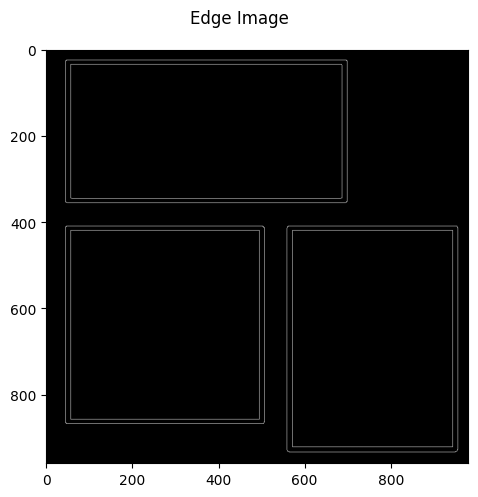

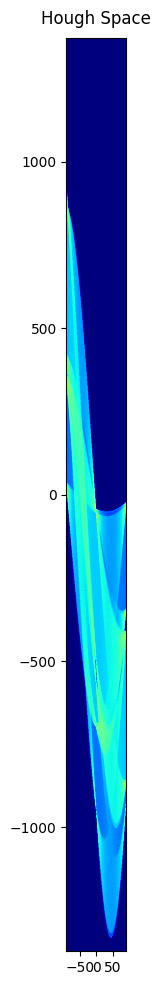

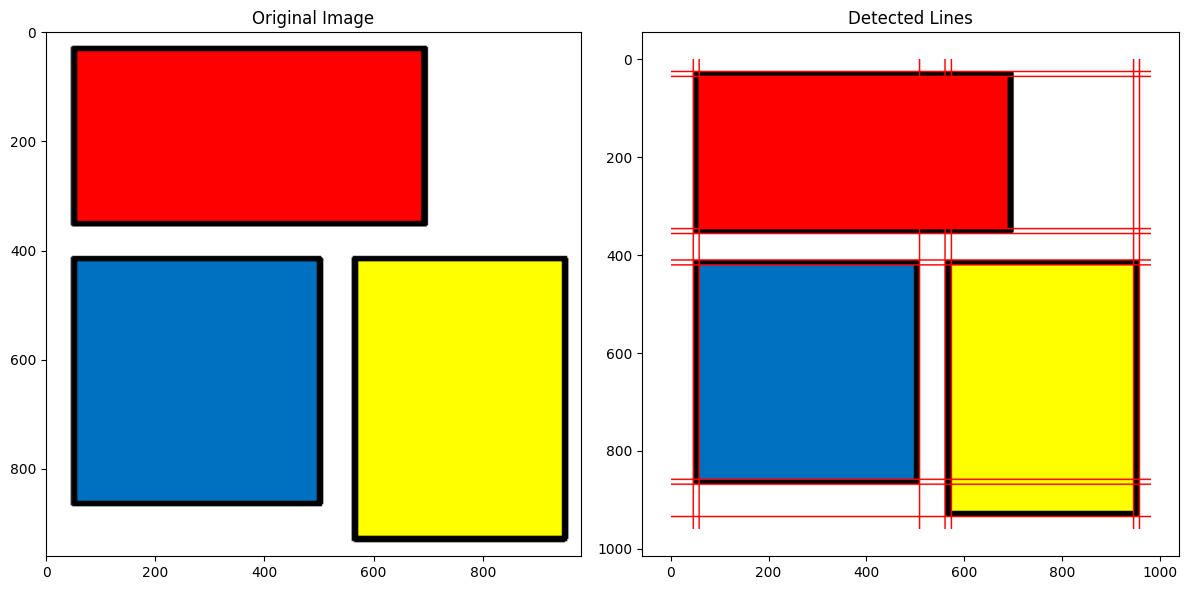

In [70]:
input_image = cv2.imread('rectangles1.png')
input_image = cv2.cvtColor(src=input_image, code=cv2.COLOR_BGR2RGB)
edge_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
edge_image = cv2.Canny(edge_image, 30, 100)
fig = plt.figure(figsize=(5, 5))
fig.suptitle('Edge Image')
plt.imshow(edge_image,  cmap="gray")
plt.tight_layout()
plt.show()
accumulator, max_points, lines, rhos, thetas, perpendicular_pairs, parallel_pairs = hough_transform_rectangular(input_image, edge_image, 16)

[((999, 934, -1000, 933, -934.0, -1.5707963267948966), (507, 1000, 507, -1000, 507.0, 0.0)), ((999, 934, -1000, 933, -934.0, -1.5707963267948966), (944, 1000, 944, -1000, 944.0, 0.0)), ((999, 934, -1000, 933, -934.0, -1.5707963267948966), (572, 1000, 572, -1000, 572.0, 0.0)), ((999, 934, -1000, 933, -934.0, -1.5707963267948966), (956, 1000, 956, -1000, 956.0, 0.0)), ((999, 934, -1000, 933, -934.0, -1.5707963267948966), (559, 1000, 559, -1000, 559.0, 0.0)), ((999, 934, -1000, 933, -934.0, -1.5707963267948966), (57, 1000, 57, -1000, 57.0, 0.0)), ((999, 934, -1000, 933, -934.0, -1.5707963267948966), (45, 1000, 45, -1000, 45.0, 0.0)), ((1000, 858, -1000, 857, -858.0, -1.5707963267948966), (507, 1000, 507, -1000, 507.0, 0.0)), ((1000, 858, -1000, 857, -858.0, -1.5707963267948966), (944, 1000, 944, -1000, 944.0, 0.0)), ((1000, 858, -1000, 857, -858.0, -1.5707963267948966), (572, 1000, 572, -1000, 572.0, 0.0)), ((1000, 858, -1000, 857, -858.0, -1.5707963267948966), (956, 1000, 956, -1000, 956

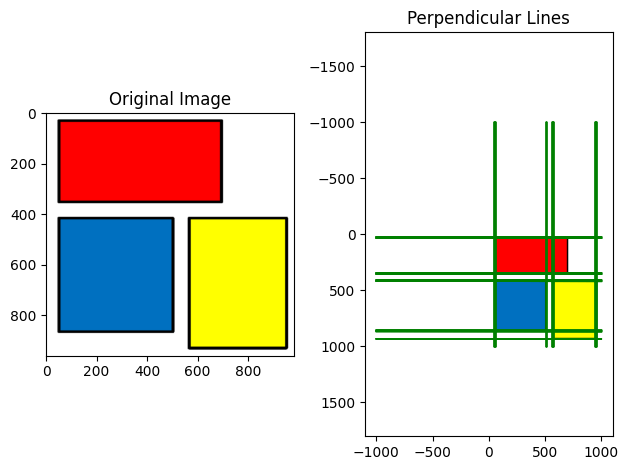

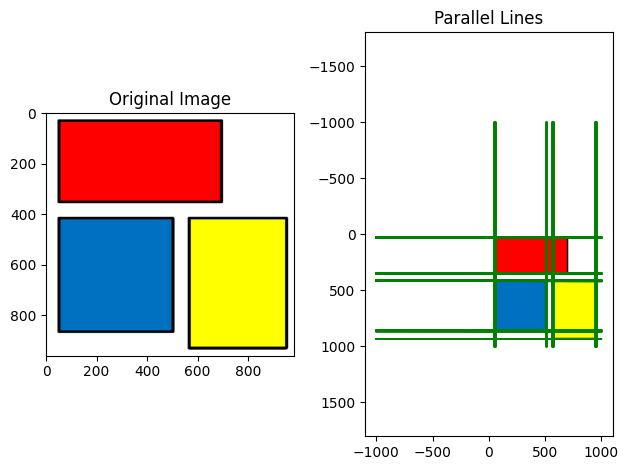

In [73]:
print(perpendicular_pairs, parallel_pairs)

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray', extent=[0, input_image.shape[1], input_image.shape[0], 0])
plt.title('Original Image')

# Detected Lines Image
plt.subplot(1, 2, 2)
plt.imshow(input_image, extent=[0, input_image.shape[1], input_image.shape[0], 0])
plt.title('Perpendicular Lines')

# Plot parallel lines
for perpendicular_pair in perpendicular_pairs:
    for line in perpendicular_pair:
        plt.plot([line[0], line[2]], [line[1], line[3]], color='green', linewidth=1)

plt.axis('equal')  # Set equal aspect ratio
plt.tight_layout()
plt.show()

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray', extent=[0, input_image.shape[1], input_image.shape[0], 0])
plt.title('Original Image')

# Detected Lines Image
plt.subplot(1, 2, 2)
plt.imshow(input_image, extent=[0, input_image.shape[1], input_image.shape[0], 0])
plt.title('Parallel Lines')

# Plot parallel lines
for parallel_pair in parallel_pairs:
    for line in parallel_pair:
        plt.plot([line[0], line[2]], [line[1], line[3]], color='green', linewidth=1)

plt.axis('equal')  # Set equal aspect ratio
plt.tight_layout()
plt.show()


120
1003


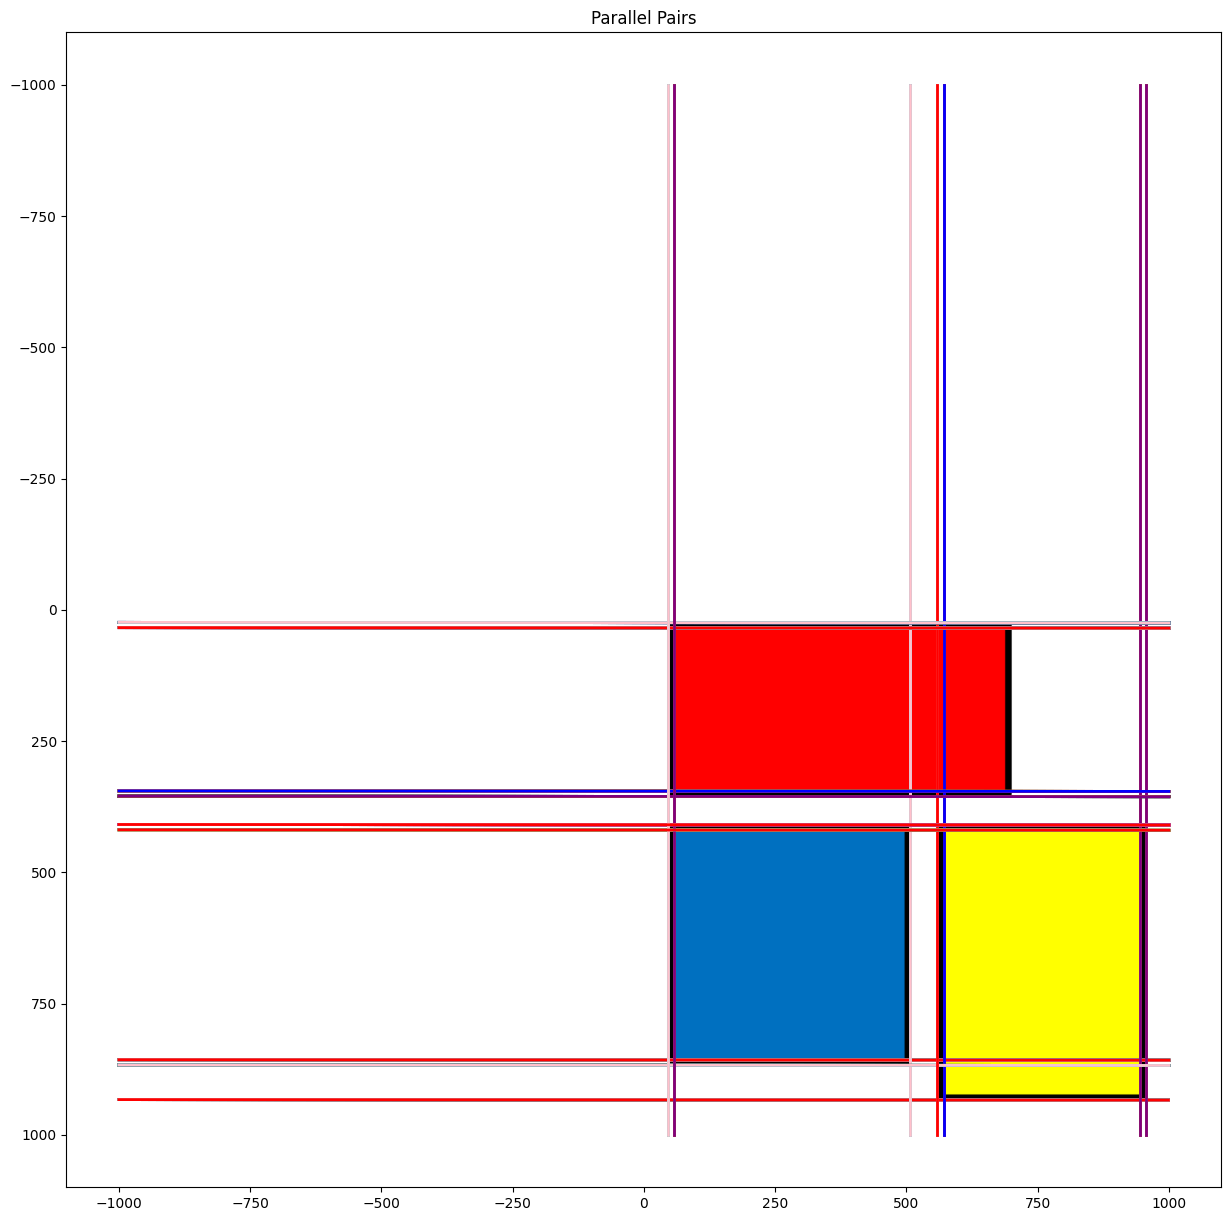

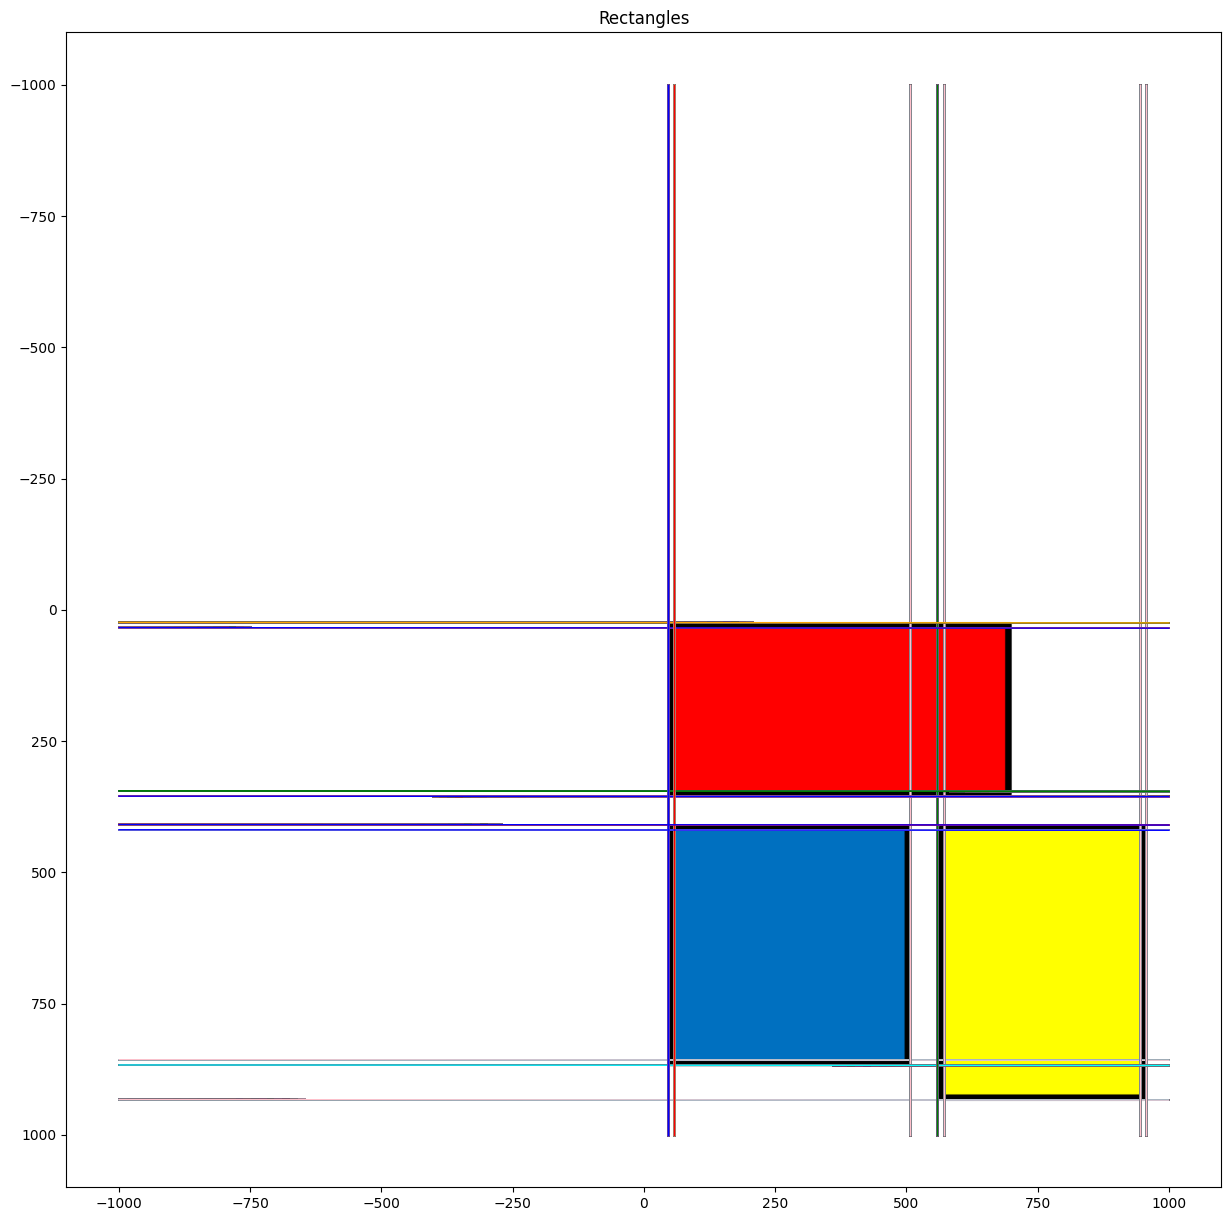

In [83]:
def are_perpendicular(line1, line2):
  theta_i, rho_i = line1[5], line1[4]
  theta_j, rho_j = line2[5], line2[4]
  angle_sum = np.abs(theta_i + theta_j)
  if np.isclose(angle_sum, np.pi/2):
      return True
  else:
      return False

def do_lines_form_rectangle(line1, line2, line3, line4):
    # Check if the angles between the lines are close to right angles
    return (
        are_perpendicular(line1, line2) and
        are_perpendicular(line2, line3) and
        are_perpendicular(line3, line4) and
        are_perpendicular(line4, line1)
    )

def find_rectangles(parallel_line_pairs):
    rectangles = []
    for i in range(len(parallel_line_pairs)):
        for j in range(i + 1, len(parallel_line_pairs)):
            line1, line2 = parallel_line_pairs[i]
            line3, line4 = parallel_line_pairs[j]

            if do_lines_form_rectangle(line1, line2, line3, line4):
                rectangles.append((line1, line2, line3, line4))

    return rectangles

def plot_parallel_lines(parallel_pairs):
    plt.figure(figsize=(15, 15))
    plt.imshow(input_image, cmap='gray')

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'pink']

    for i, parallel_pair in enumerate(parallel_pairs):
        color_index = i % len(colors)

        for line in parallel_pair:
            plt.plot([line[0], line[2]], [line[1], line[3]], color=colors[color_index], linewidth=2)

    plt.title('Parallel Pairs')
    plt.show()

def plot_rectangles(rectangles):
  plt.figure(figsize=(15, 15))
  plt.imshow(input_image, cmap='gray')
  colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'pink']

  for i, rectangle in enumerate(rectangles):
      for line in rectangle:
          color_index = i % len(colors)
          plt.plot([line[0], line[2]], [line[1], line[3]], color=colors[color_index], linewidth=1)

  plt.title('Rectangles')
  plt.show()

print(len(parallel_pairs))
rectangles = find_rectangles(parallel_pairs)
print(len(rectangles))
plot_parallel_lines(parallel_pairs)
plot_rectangles(rectangles)

